# Pylidc package for EDA of LIDC-IDRI dataset

In [1]:
import pylidc as pl

## Count number of CT scans

In [2]:
scans = pl.query(pl.Scan)
print(scans.count())

1018


## Explore Scan object

In [3]:
pid = 'LIDC-IDRI-0078'
patient_scans = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid)
print(patient_scans.count())

1


In [4]:
scan = patient_scans.first()

In [5]:
print(len(scan.annotations))

13


In [6]:
scan.annotations

[Annotation(id=1,scan_id=1),
 Annotation(id=2,scan_id=1),
 Annotation(id=3,scan_id=1),
 Annotation(id=4,scan_id=1),
 Annotation(id=5,scan_id=1),
 Annotation(id=6,scan_id=1),
 Annotation(id=7,scan_id=1),
 Annotation(id=8,scan_id=1),
 Annotation(id=9,scan_id=1),
 Annotation(id=10,scan_id=1),
 Annotation(id=11,scan_id=1),
 Annotation(id=12,scan_id=1),
 Annotation(id=13,scan_id=1)]

In [7]:
nods = scan.cluster_annotations()
print(len(nods))

4


In [8]:
nods

[[Annotation(id=2,scan_id=1),
  Annotation(id=6,scan_id=1),
  Annotation(id=10,scan_id=1),
  Annotation(id=13,scan_id=1)],
 [Annotation(id=1,scan_id=1),
  Annotation(id=5,scan_id=1),
  Annotation(id=9,scan_id=1),
  Annotation(id=12,scan_id=1)],
 [Annotation(id=8,scan_id=1)],
 [Annotation(id=3,scan_id=1),
  Annotation(id=4,scan_id=1),
  Annotation(id=7,scan_id=1),
  Annotation(id=11,scan_id=1)]]

## Visualize one scan

In [10]:
vol = scan.to_volume()

Loading dicom files ... This may take a moment.


In [12]:
vol.shape

(512, 512, 87)

Loading dicom files ... This may take a moment.


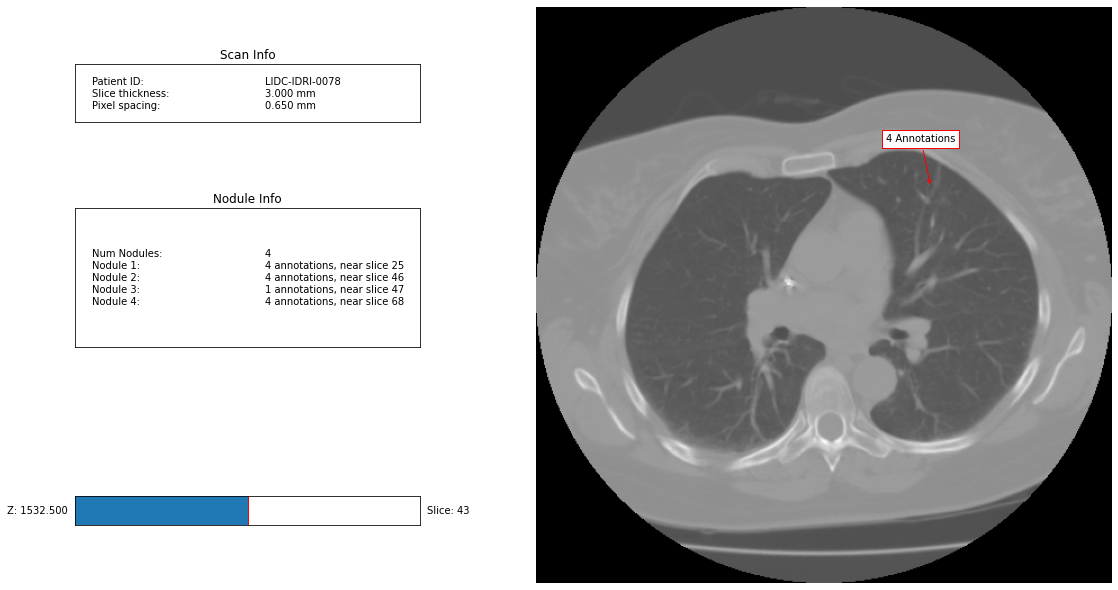

In [13]:
scan.visualize(annotation_groups=nods)

## Explore Annotation object

In [15]:
anns = scan.annotations
ann = anns[0]
ann

Annotation(id=1,scan_id=1)

In [18]:
print(ann.malignancy, ann.Malignancy)
print(ann.margin, ann.Margin)

3 Indeterminate
4 Near Sharp


In [21]:
print(pl.annotation_feature_names)

('subtlety', 'internalStructure', 'calcification', 'sphericity', 'margin', 'lobulation', 'spiculation', 'texture', 'malignancy')


In [23]:
ann.print_formatted_feature_table()

Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Obvious                  | 5 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Absent                   | 6 
Sphericity         | Ovoid                    | 3 
Margin             | Near Sharp               | 4 
Lobulation         | No Lobulation            | 1 
Spiculation        | No Spiculation           | 1 
Texture            | Solid                    | 5 
Malignancy         | Indeterminate            | 3 


## Visualize annotations

In [25]:
ann.contours

[Contour(id=1,annotation_id=1),
 Contour(id=2,annotation_id=1),
 Contour(id=3,annotation_id=1),
 Contour(id=4,annotation_id=1),
 Contour(id=5,annotation_id=1),
 Contour(id=6,annotation_id=1)]

In [42]:
c = ann.contours[0]
print(c.image_k_position)
print(c.to_matrix())

49
[[172 364  49]
 [171 364  49]
 [170 364  49]
 [169 365  49]
 [168 365  49]
 [167 365  49]
 [166 365  49]
 [165 365  49]
 [164 365  49]
 [163 365  49]
 [164 364  49]
 [164 363  49]
 [165 362  49]
 [166 361  49]
 [167 360  49]
 [168 359  49]
 [169 359  49]
 [170 358  49]
 [171 359  49]
 [171 360  49]
 [170 361  49]
 [169 362  49]
 [169 363  49]
 [171 363  49]
 [172 364  49]]


In [26]:
mask = ann.boolean_mask()
print(mask.shape, mask.dtype)

(34, 27, 6) bool


In [27]:
bbox = ann.bbox()
print(bbox)

(slice(151, 185, None), slice(349, 376, None), slice(44, 50, None))


In [28]:
vol = ann.scan.to_volume()
print(vol.shape)
print(vol[bbox].shape)

Loading dicom files ... This may take a moment.
(512, 512, 87)
(34, 27, 6)


In [29]:
print(ann.bbox_dims())

[21.45 16.9  15.  ]


/Users/felix/.pyenv/versions/3.8.5/lib/python3.8/_collections_abc.py:666: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  self[key]
/Users/felix/code/ml/lung-cancer-detection/venv/lib/python3.8/site-packages/pylidc/Annotation.py:750: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  verts, faces, _, _= marching_cubes(mask.astype(np.float), 0.5,
/Users/felix/code/ml/lung-cancer-detection/venv/lib/python3.8/site-packages/pylidc/Annotation.py:759: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  facecolors=plt.cm.cmap_d[cmap](t))


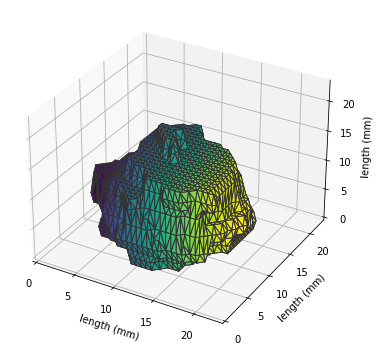

In [30]:
ann.visualize_in_3d()

Loading dicom files ... This may take a moment.


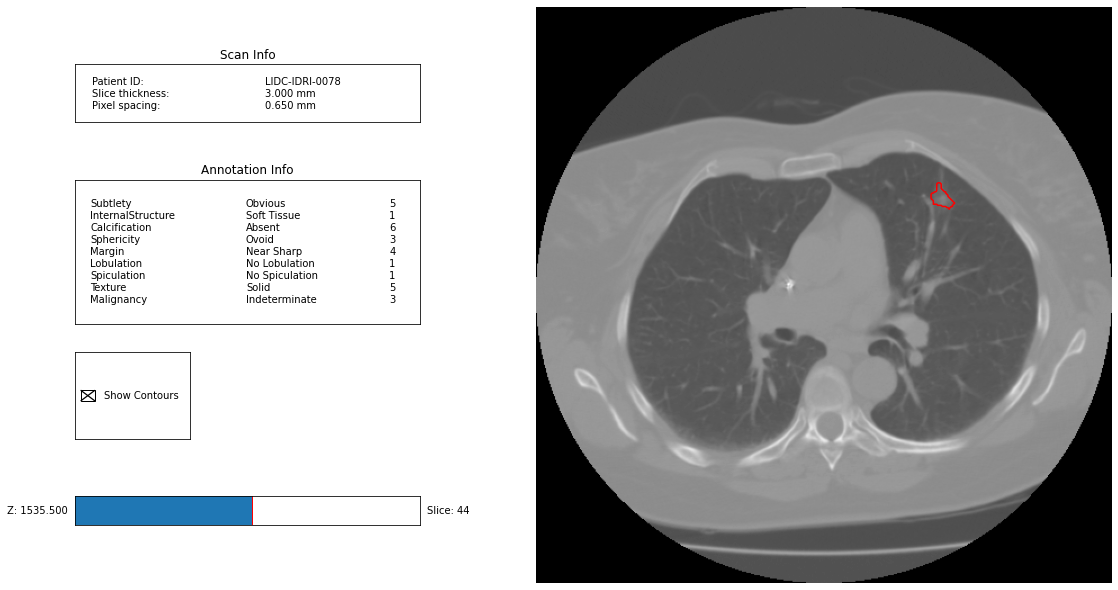

In [32]:
ann.visualize_in_scan()

## Visualize annotation consensus

In [65]:
from functools import reduce

import numpy as np

from skimage.measure import find_contours
from pylidc.utils import consensus
import matplotlib.pyplot as plt

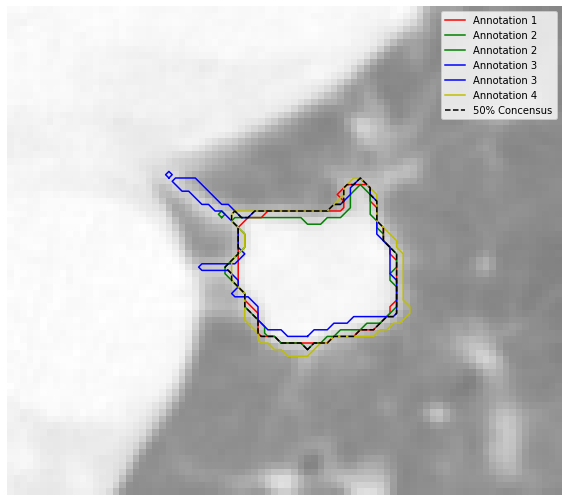

In [69]:
# Get annotations for one node cluster
anns = nods[0]

# Perform concensus consolidation and pad slices for visualization
cmask, cbbox, masks = consensus(anns, clevel=0.5, pad=[(20,20), (20,20), (0,0)])

# Get central slice of computed bounding box
k = int(0.5*(cbbox[2].stop - cbbox[2].start))

# Plot the result
fix, ax = plt.subplots(1, 1, figsize=(8,8))
ax.imshow(vol[cbbox][:,:,k], cmap=plt.cm.gray, alpha=0.5)

## Plot annotation contours for kth slice
colors = ['r', 'g', 'b', 'y']
for j in range(len(masks)):
    for c in find_contours(masks[j][:,:,k].astype(float), 0.5):
        label = f"Annotation {j+1}"
        plt.plot(c[:,1], c[:,0], colors[j], label=label)

# Plot the 50% consensus contour for kth slice
for c in find_contours(cmask[:,:,k].astype(float), 0.5):
    plt.plot(c[:,1], c[:,0], '--k', label="50% Concensus")
    
ax.axis('off')
ax.legend()
plt.tight_layout()
plt.show()